# Life-time Broadened Case

This is the code for the cold vapor cell. In this code, the decay from states 1 and 2 is set to 0 but can be modified.


#### Electromagnetically Induced Transparency (EIT) Simulation Module


This module implements a suite of routines to compute and visualize optical density (OD)
and field propagation in a three‐level Λ‐type atomic system. It comprises:

#### 1. calculate_OD_1(Om_1, delta_1, delta_2)
   - Computes the steady‐state density‐matrix element ρ₃₁ under arbitrary probe (Ω₁)
     and coupling (Ω₂) Rabi frequencies, using an analytical inversion of the Liouville
     equations at each propagation step z.
   - Propagates both fields through an atomic vapor cell of length L by updating Ω₁(z)
     and Ω₂(z) at each slice via the semiclassical Maxwell–Bloch coupling.
   - Returns arrays of input/output Rabi frequencies, populations (ρ₁₁, ρ₂₂, ρ₃₃),
     coherences (ρ₃₁, ρ₃₂), and the z‐axis grid for downstream analysis.

#### 2. Constants K_1, K_2
   
   - Conversion factors between Rabi frequency squared (Ω²) and optical power (P)
     for the probe and coupling transitions, respectively.
   - Derived from P = (π c ε₀ ℏ² w₀² / 4 μᵢⱼ²) Ωᵢⱼ², scaled to MHz and SI units.

#### 3. Axis‐conversion helpers (x_forward, x_inverse, y_forward, y_inverse, …)
   
   - Functions to map between Rabi‐frequency‐squared (Ω²/Γ₃²) and physical power (W)
     along the top and right axes of each plot.

#### 4. plot_OD(Om_1_list, delta_1_list, delta_2_list)
   
   - For each set of detunings (Δ₁, Δ₂), runs calculate_OD_1 to obtain transmitted
     field amplitudes.
   - Generates two publication‐quality figures:
     • Output probe intensity vs. input coupling Rabi‐power (Ω₂² axis on bottom
       and P₂ axis on top)
     • Output coupling intensity vs. input coupling Rabi‐power (same dual axes)
   - Configures secondary axes with the above helpers, labels, grid, legend,
     and displays via Matplotlib.

#### 5. Interactive widget (“Run Simulation” button)
   
   - Provides a simple Jupyter/IPython interface to launch plot_OD with a preset
     trio of probe Rabi frequencies and detunings.
   - Useful for rapid exploration during notebook‐based presentations or live demos.
"""


### Libraries

In [2]:
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Image
from scipy.linalg import LinAlgError, solve
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from matplotlib.ticker import MaxNLocator

### Parameters

In [5]:
Transparency_Omega_1 = None
Transparency_Omega_2 = None
Om_2_list_adapted = None

# Constants
epsilon_0 = 8.854e-12  # Vacuum permittivity (F/m)
hbar = 1.054e-34       # Reduced Planck's constant (J·s)
mu_13 = 1.366e-29     # Dipole moment between states (|1> and |3>) (C·m)
mu_23 = 1.058e-29     # Dipole moment between states (|2> and |3>) (C·m)
c = 3e8

Gamma3 = 2 * np.pi * 6   # (MHz)
Gamma31 = 0.5 * Gamma3   # Decay from level 3 to level 1 (MHz)
Gamma32 = Gamma23 = 0.5 * Gamma3   # Decay from level 3 to level 2 (MHz)
Gamma12 = Gamma21 = 0 * Gamma3    # Decay rates between levels 1 and 2 (MHz)
gamma13 = (Gamma3 + Gamma12)/2  # Decoherence rate between levels 1 and 3 (MHz)
gamma23 = (Gamma3 + Gamma21)/2  # Decoherence rate between levels 2 and 3 (MHz)
gamma12 = (Gamma12 + Gamma21)/2  # Decoherence rate between ground states (MHz)

w_1 = 2 * np.pi * 3.771120414e14
w_2 = 2 * np.pi * 3.771052067e14
k_1 = w_1 / 3e8
k_2 = w_2 / 3e8
w0 = 71e-6          # In m
L = 0.02        # Length in meters
z = 0.00005    # Step size in meters

OD_0 = 50
N = OD_0 / ((4 * np.pi * mu_13**2 * L) / (Gamma3 * 10**6 * hbar * epsilon_0 * 795e-9))

print("Atomic Density (OD0={:.2f}) = {:.2e}".format(OD_0, N))

Atomic Density (OD0=50.00) = 2.98e+16


## Main Code

Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

Processing z step 999/3999
Processing z step 1999/3999
Processing z step 2999/3999
0j
Processing z step 999/3999
Processing z step 1999/3999
Processing z step 2999/3999
0j
Processing z step 999/3999
Processing z step 1999/3999
Processing z step 2999/3999
0j


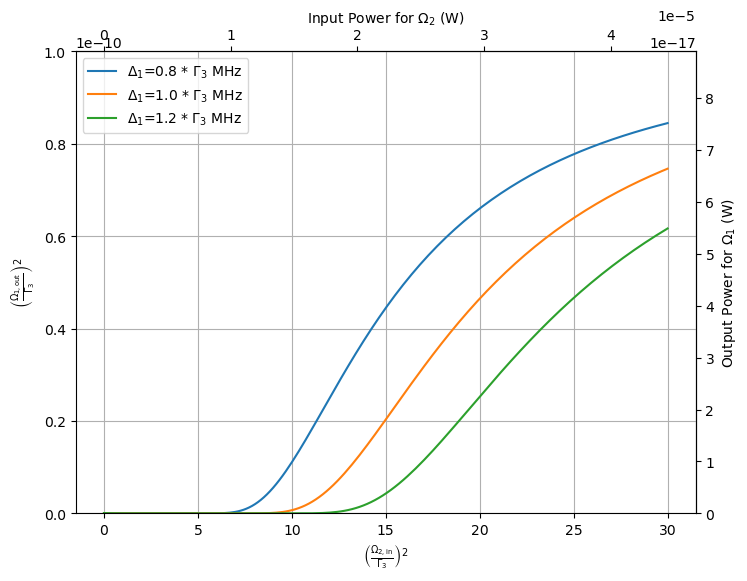

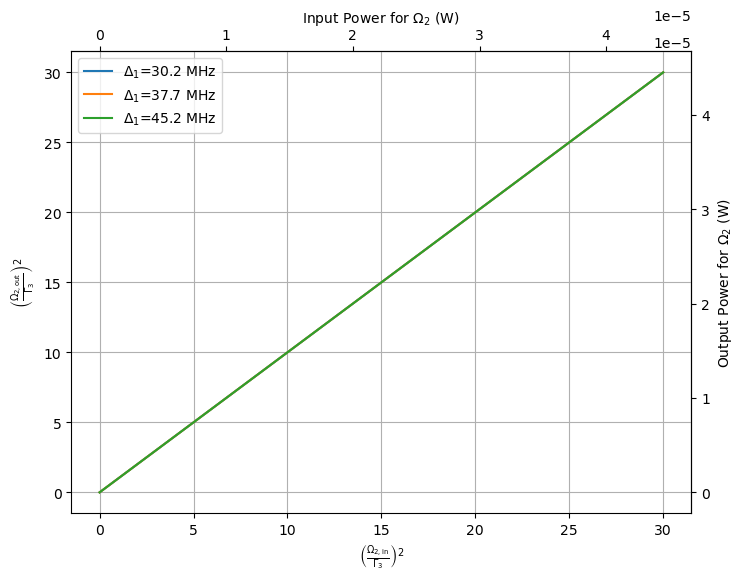

In [48]:
# Backend function to calculate OD based on user input
def calculate_OD_1(Om_1=1.0, delta_1=0.0, delta_2=0.0):
    n_rabi = 200
    Om_2_list_adapted = np.linspace(0, np.sqrt(30 * Gamma3**2), n_rabi, dtype=complex)  # Coupling Rabi frequency range (MHz)
    Om_2_list = Om_2_list_adapted.copy()
    Om_1_list = np.full(n_rabi, Om_1, dtype=complex)
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = np.zeros((nz, n_rabi), dtype=complex)
    Om_1_vs_z = np.zeros((nz, n_rabi), dtype=complex)

    # Initialize arrays with zeros to store populations
    rho11_values = np.zeros((nz, n_rabi), dtype=float)
    rho22_values = np.zeros((nz, n_rabi), dtype=float)
    rho33_values = np.zeros((nz, n_rabi), dtype=float)

    # Initialize arrays to store rho31 and rho32
    rho31_values = np.zeros((nz, n_rabi), dtype=complex)
    rho32_values = np.zeros((nz, n_rabi), dtype=complex)
    
    Om_2_actual = 0 + 0*1j
    Om_1_actual = 0 + 0*1j

    for i in range(nz):
        if i == nz//4 or i == nz//2 or i == 3*nz//4: 
            print(f"Processing z step {i}/{nz}")
        
        for j in range(len(Om_2_list)):
            
            Om_2_actual = Om_2_list[j]     
            Om_1_actual = Om_1_list[j]      

            delta_1_actual = delta_1
            delta_2_actual = delta_2

            
            # Construct A and b to compute matrix linear solution
            numerator = 2 * Om_1_actual * (delta_1_actual - delta_2_actual + 1j * gamma12)
            denominator = (
                Om_2_actual * np.conjugate(Om_2_actual)
                - 4 * (delta_1_actual - delta_2_actual + 1j * gamma12)
                      * (delta_1_actual + 1j * gamma13)
            )
            rho31 = numerator / denominator
                     
                        
            # Update the Rabi frequencies
            Om_1_list[j] = Om_1_actual + z * (1j) * (k_1 / (epsilon_0 * hbar)) * N * rho31 * mu_13**2 / 1e6
            Om_2_list[j] = Om_2_actual + z * (1j) * (k_2 / (epsilon_0 * hbar)) * N * 0 * mu_23**2 / 1e6
            
    

        # Record Rabi frequencies at this z step
        Om_1_vs_z[i] = Om_1_list.copy()
        Om_2_vs_z[i] = Om_2_list.copy()
    
    print(rho31_values[0][1])
    # Convert lists to numpy arrays
    Om_1_vs_z = np.array(Om_1_vs_z)  # Shape: (nz, n_rabi)
    Om_2_vs_z = np.array(Om_2_vs_z)  # Shape: (nz, n_rabi)
    
    return Om_2_list, Om_1_list, rho11_values, rho22_values, rho33_values, rho31_values, rho32_values, Om_2_vs_z, Om_1_vs_z, z_array, Om_2_list_adapted

# Suppose mu_2 is mu_23 for Omega_2, mu_1 is mu_13 for Omega_1
K_2 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_23**2)
K_1 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)

# For the X-axis (which is Omega_2^2 -> power):
def x_forward(omega2_sq):
    return K_2 * omega2_sq * (Gamma3**2) # because P = K_2 * (omega2)^2
def x_inverse(power_value):
    return power_value / (K_2 * (Gamma3**2))
# For the Y-axis (which is Omega_1^2 -> power):
def y_forward(omega1_sq):
    return K_1 * omega1_sq * (Gamma3**2)
def y_inverse(power_value):
    return power_value / (K_1 * (Gamma3**2))
def y_forward_2(omega2_sq):
    return K_2 * omega2_sq * (Gamma3**2)  # Por ejemplo, si K_2 corresponde a la transición de Ω2
def y_inverse_2(power_value):
    return power_value / (K_2 * (Gamma3**2))

def plot_OD(Om_1, delta_1, delta_2):
    
    Output_Omega_1_list = [0]*len(delta_1)
    Output_Omega_2_list = [0]*len(delta_1)
        
    # Calculate Power of I_1
    P = (np.pi * c * epsilon_0 * (Om_1*1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)
    
    for i in range(len(delta_1)):    
        Om_2_list, Om_1_list, rho11_values, rho22_values, rho33_values, rho31_values, rho32_values, Om_2_vs_z, Om_1_vs_z, z_array, Om_2_list_adapted = calculate_OD_1(Om_1[i], delta_1[i], delta_2[i])
        # Calculate input and output intensity 
        
        Output_Omega_1_list[i] = np.abs(Om_1_vs_z[-1, :])
        Output_Omega_2_list[i] = np.abs(Om_2_vs_z[-1, :])
    
    fig, ax1 = plt.subplots(figsize=(8,6))
    for i in range(len(delta_1)):
        ax1.plot((np.real(Om_2_list_adapted))**2/Gamma3**2,
                 (Output_Omega_1_list[i])**2/Gamma3**2,
                 label=f'$\\Delta_1$={(delta_1[i]/Gamma3):.1f} * $\\Gamma_3$ MHz')

    ax1.set_xlabel(r'$\left(\frac{\Omega_{2,\mathrm{in}}}{\Gamma_3}\right)^2$')
    ax1.set_ylabel(r'$\left(\frac{\Omega_{1,\mathrm{out}}}{\Gamma_3}\right)^2$')
    ax1.grid(True)
    
    #print(((np.real(Om_2_list_adapted))**2/Gamma3**2).tolist())
    #print(((Output_Omega_1_list[i])**2/Gamma3**2).tolist())

    # Create the top X-axis for power of Omega_2:
    ax_top = ax1.secondary_xaxis('top', functions=(x_forward, x_inverse))
    ax_top.set_xlabel('Input Power for $\\Omega_2$ (W)')

    # Create the right Y-axis for power of Omega_1:
    ax_right = ax1.secondary_yaxis('right', functions=(y_forward, y_inverse))
    ax_right.set_ylabel('Output Power for $\\Omega_1$ (W)')
    
    # Save the figure to the specified path
    save_path = r"C:\Users\ruben\OneDrive\Escritorio\Purdue\AONN Research\Paper Figures\Figure3b.pdf"
    #plt.savefig(save_path, format='eps', dpi=300)
    plt.legend()
    plt.ylim(0,1e-10)
    plt.show()

    fig, ax2 = plt.subplots(figsize=(8,6))
    for i in range(len(delta_1)):
        ax2.plot((np.real(Om_2_list_adapted))**2/Gamma3**2,
                 (Output_Omega_2_list[i])**2/Gamma3**2,
                 label=f'$\\Delta_1$={delta_1[i]:.1f} MHz')

    ax2.set_xlabel(r'$\left(\frac{\Omega_{2,\mathrm{in}}}{\Gamma_3}\right)^2$')
    ax2.set_ylabel(r'$\left(\frac{\Omega_{2,\mathrm{out}}}{\Gamma_3}\right)^2$')
    ax2.grid(True)
    ax2.legend(loc='best')

    # Top X-axis for input power (still use x_forward / x_inverse for the coupling beam’s dipole moment mu_23):
    ax2_top = ax2.secondary_xaxis('top', functions=(x_forward, x_inverse))
    ax2_top.set_xlabel('Input Power for $\\Omega_2$ (W)')

    # Right Y-axis for output power (again use mu_23, because it’s the same beam if it’s $\Omega_2$):
    ax2_right = ax2.secondary_yaxis('right', functions=(y_forward_2, y_inverse_2))  
    # or if you want the same function names but with mu_23 inside, define them accordingly.
    ax2_right.set_ylabel('Output Power for $\\Omega_2$ (W)')
    
    save_path = r"C:\Users\ruben\OneDrive\Escritorio\Purdue\AONN Research\Paper Figures\Figure4b.pdf"
    #plt.savefig(save_path, format='eps', dpi=300)
    plt.show()
    

# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values
    Om_1 = np.array([0.00001, 0.00001, 0.00001]) * Gamma3
    delta_1 = np.array([0.8, 1, 1.2]) * Gamma3
    delta_2 = 0 * delta_1
    
    # Call the plot_OD function with these values
    plot_OD(Om_1, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the button
display(run_button)


### Variable laser now Laser1

In [36]:
# Backend function to calculate OD based on user input
def calculate_OD_1(Om_2=1.0, delta_1=0.0, delta_2=0.0, Gamma12=0):
    Gamma21 = Gamma12    # Decay rates between levels 1 and 2 (MHz)
    gamma13 = (Gamma3 + Gamma12)/2  # Decoherence rate between levels 1 and 3 (MHz)
    gamma23 = (Gamma3 + Gamma21)/2  # Decoherence rate between levels 2 and 3 (MHz)
    gamma12 = (Gamma12 + Gamma21)/2 + 1e-3 * Gamma3   # Decoherence rate between ground states (MHz)
    n_rabi = 250
    Om_1_list_adapted = np.linspace(0, np.sqrt(30 * Gamma3**2), n_rabi, dtype=complex)  # Coupling Rabi frequency range (MHz)
    Om_1_list = Om_1_list_adapted.copy()
    Om_2_list = np.full(n_rabi, Om_2, dtype=complex)
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = np.zeros((nz, n_rabi), dtype=complex)
    Om_1_vs_z = np.zeros((nz, n_rabi), dtype=complex)

    # Initialize arrays with zeros to store populations
    rho11_values = np.zeros((nz, n_rabi), dtype=float)
    rho22_values = np.zeros((nz, n_rabi), dtype=float)
    rho33_values = np.zeros((nz, n_rabi), dtype=float)

    # Initialize arrays to store rho31 and rho32
    rho31_values = np.zeros((nz, n_rabi), dtype=complex)
    rho32_values = np.zeros((nz, n_rabi), dtype=complex)
    
    Om_2_actual = 0 + 0*1j
    Om_1_actual = 0 + 0*1j

    for i in range(nz):
        if i == nz//4 or i == nz//2 or i == 3*nz//4: 
            print(f"Processing z step {i}/{nz}")
        
        for j in range(0, len(Om_1_list)):
            
            Om_2_actual = Om_2_list[j]     
            Om_1_actual = Om_1_list[j]      

            delta_1_actual = delta_1
            delta_2_actual = delta_2

            # Construct A and b to compute matrix linear solution
            # Define the imaginary unit
            I = 1j

            # Construct the matrix A
            A = np.array([
                # Row 1
                [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
                # Row 2
                [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                # Row 3
                [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                # Row 4
                [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                # Row 5
                [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                # Row 6
                [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                # Row 7
                [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                # Row 8
                [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
            ], dtype=complex)
            
            # Construct the vector b
            b = np.array([
                Gamma31,
                0,
                I*np.conjugate(Om_1_actual)/2,
                0,
                Gamma32,
                I*np.conjugate(Om_2_actual)/2,
                -I*Om_1_actual/2,
                -I*Om_2_actual/2
            ], dtype=complex)
            
            # Solve the linear system A * v = b
            cond_number = np.linalg.cond(A)
            if cond_number > 1e12:
                print("Matrix is ill-conditioned")
            try:
                v = solve(A, b)
            except LinAlgError:
                # Handle singular matrix
                print("nan")
                rho11_values[i][j] = np.nan
                rho22_values[i][j] = np.nan
                rho33_values[i][j] = np.nan
                rho31_values[i][j] = np.nan
                rho32_values[i][j] = np.nan
                continue


            # Extract the solutions
            rho11 = np.real(v[0])
            rho12 = v[1]
            rho13 = v[2]
            rho21 = v[3]
            rho22 = np.real(v[4])
            rho23 = v[5]
            rho31 = v[6]
            rho32 = v[7]

            # Compute rho33
            rho33 = 1 - rho11 - rho22

            # Store the populations
            rho11_values[i][j] = rho11
            rho22_values[i][j] = rho22
            rho33_values[i][j] = rho33
            rho31_values[i][j] = rho31
            rho32_values[i][j] = rho32
                     
                        
            # Update the Rabi frequencies
            Om_1_list[j] = Om_1_actual + z * (1j) * (k_1 / (epsilon_0 * hbar)) * N * rho31 * mu_13**2 / 1e6
            Om_2_list[j] = Om_2_actual + z * (1j) * (k_2 / (epsilon_0 * hbar)) * N * rho32 * mu_23**2 / 1e6
        

        # Record Rabi frequencies at this z step
        Om_1_vs_z[i] = Om_1_list.copy()
        Om_2_vs_z[i] = Om_2_list.copy()
    
    # Convert lists to numpy arrays
    Om_1_vs_z = np.array(Om_1_vs_z)  # Shape: (nz, n_rabi)
    Om_2_vs_z = np.array(Om_2_vs_z)  # Shape: (nz, n_rabi)
    
    return Om_2_list, Om_1_list, rho11_values, rho22_values, rho33_values, rho31_values, rho32_values, Om_2_vs_z, Om_1_vs_z, z_array, Om_1_list_adapted

# Suppose mu_2 is mu_23 for Omega_2, mu_1 is mu_13 for Omega_1
K_2 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_23**2)
K_1 = (np.pi * c * epsilon_0 * (1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)

# For the X-axis (which is Omega_2^2 -> power):
def x_forward(omega1_sq):
    return K_1 * omega1_sq * (Gamma3**2) # because P = K_2 * (omega2)^2
def x_inverse(power_value):
    return power_value / (K_1 * (Gamma3**2))
# For the Y-axis (which is Omega_1^2 -> power):
def y_forward(omega2_sq):
    return K_2 * omega2_sq * (Gamma3**2)
def y_inverse(power_value):
    return power_value / (K_2 * (Gamma3**2))
def y_forward_2(omega1_sq):
    return K_1 * omega1_sq * (Gamma3**2) 
def y_inverse_2(power_value):
    return power_value / (K_1 * (Gamma3**2))

def plot_OD(Om_2, delta_1, delta_2):
    
    Output_Omega_1_list = [0]*len(delta_1)
    Output_Omega_2_list = [0]*len(delta_1)
        
    # Calculate Power of I_1
    P = (np.pi * c * epsilon_0 * (Om_2*1e6)**2 * hbar**2 * w0**2) / (4 * mu_13**2)
    
    Gamma12_list = [0.0*Gamma3, 0*Gamma3, 0*Gamma3]
    
    for i in range(len(delta_1)):    
        Om_2_list, Om_1_list, rho11_values, rho22_values, rho33_values, rho31_values, rho32_values, Om_2_vs_z, Om_1_vs_z, z_array, Om_1_list_adapted = calculate_OD_1(Om_2[i], delta_1[i], delta_2[i], Gamma12_list[i])
        # Calculate input and output intensity 
        
        Output_Omega_1_list[i] = np.abs(Om_1_vs_z[-1, :])
        Output_Omega_2_list[i] = np.abs(Om_2_vs_z[-1, :])
    
    fig, ax1 = plt.subplots(figsize=(8,6))
    for i in range(len(delta_1)):
        ax1.plot((np.real(Om_1_list_adapted))**2/Gamma3**2,
                 (Output_Omega_2_list[i])**2/Gamma3**2,
                 label=f'$\\Delta_1$={delta_1[i]:.1f} MHz')

    ax1.set_xlabel(r'$\left(\frac{\Omega_{1,\mathrm{in}}}{\Gamma_3}\right)^2$')
    ax1.set_ylabel(r'$\left(\frac{\Omega_{2,\mathrm{out}}}{\Gamma_3}\right)^2$')
    ax1.grid(True)
    ax1.legend(loc='best')

    # Create the top X-axis for power of Omega_1:
    ax_top = ax1.secondary_xaxis('top', functions=(x_forward, x_inverse))
    ax_top.set_xlabel('Input Power for $\\Omega_1$ (W)')

    # Create the right Y-axis for power of Omega_2:
    ax_right = ax1.secondary_yaxis('right', functions=(y_forward, y_inverse))
    ax_right.set_ylabel('Output Power for $\\Omega_2$ (W)')
    save_path = r"C:\Users\ruben\OneDrive\Escritorio\Purdue\AONN Research\Paper Figures\Figure4c.pdf"
    #plt.savefig(save_path, format='eps', dpi=300)
    plt.show()

    fig, ax2 = plt.subplots(figsize=(8,6))
    for i in range(len(delta_1)):
        ax2.plot((np.real(Om_1_list_adapted))**2/Gamma3**2,
                 (Output_Omega_1_list[i])**2/Gamma3**2,
                 label=f'$\\Delta_1$={delta_1[i]:.1f} MHz')

    ax2.set_xlabel(r'$\left(\frac{\Omega_{1,\mathrm{in}}}{\Gamma_3}\right)^2$')
    ax2.set_ylabel(r'$\left(\frac{\Omega_{1,\mathrm{out}}}{\Gamma_3}\right)^2$')
    ax2.grid(True)
    ax2.legend(loc='best')

    # Top X-axis for input power (still use x_forward / x_inverse for the coupling beam’s dipole moment mu_23):
    ax2_top = ax2.secondary_xaxis('top', functions=(x_forward, x_inverse))
    ax2_top.set_xlabel('Input Power for $\\Omega_1$ (W)')

    # Right Y-axis for output power (again use mu_23, because it’s the same beam if it’s $\Omega_2$):
    ax2_right = ax2.secondary_yaxis('right', functions=(y_forward_2, y_inverse_2))  
    ax2_right.set_ylabel('Output Power for $\\Omega_1$ (W)')
    # Save the figure to the specified path
    save_path = r"C:\Users\ruben\OneDrive\Escritorio\Purdue\AONN Research\Paper Figures\Figure3c.pdf"
    plt.savefig(save_path, format='eps', dpi=300)
    plt.show()
    

# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values
    Om_2 = np.array([1, 3, 10]) * Gamma3
    delta_1 = Om_2/2
    delta_2 = 0 * delta_1
    
    # Call the plot_OD function with these values
    plot_OD(Om_2, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the button
display(run_button)


Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

### Maximum absorption ReLU

Variable Om_2

In [7]:
def calculate_OD_1(Om_2=1.0, last_omega=1):
    n_detunings = 351
    Om_1_list = np.full(n_detunings, 12 * Gamma3, dtype=complex)
    Om_2_list = np.full(n_detunings, Om_2, dtype=complex)
    Om_1_initial = Om_1_list[0]
    Om_2_initial = Om_2_list[0]
    
    detuning_list = np.linspace(-1 * Om_1_initial, 1 * Om_1_initial, n_detunings, dtype=complex)
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = np.zeros((nz, n_detunings), dtype=complex)
    Om_1_vs_z = np.zeros((nz, n_detunings), dtype=complex)

    # Initialize arrays with zeros to store populations
    rho11_values = np.zeros((nz, n_detunings), dtype=float)
    rho22_values = np.zeros((nz, n_detunings), dtype=float)
    rho33_values = np.zeros((nz, n_detunings), dtype=float)

    # Initialize arrays to store rho31 and rho32
    rho31_values = np.zeros((nz, n_detunings), dtype=complex)
    rho32_values = np.zeros((nz, n_detunings), dtype=complex)
    
    Om_2_actual = 0 + 0j
    Om_1_actual = 0 + 0j

    for i in range(nz):
        if i == nz/4 or i == nz/2 or i == 3*nz/4: 
            print(f"Processing z step {i}/{nz}")
        
        for j in range(len(detuning_list)):
            
            Om_2_actual = Om_2_list[j]    
            Om_1_actual = Om_1_list[j]      

            # We'll just vary delta_2 here:
            delta_2_actual = 0
            delta_1_actual = detuning_list[j]

            I = 1j  # imaginary unit

            # Construct the matrix A
            A = np.array([
                [Gamma31 + Gamma12, 0,                I*Om_1_actual/2,             0,
                 Gamma31 - Gamma21, 0,               -I*np.conjugate(Om_1_actual)/2,  0],
                
                [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0,
                 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                
                [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0,
                 I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                
                [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual),
                 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                
                [Gamma32 - Gamma12, 0, 0, 0,
                 Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                
                [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2,
                 I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                
                [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2,
                 -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                
                [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0,
                 -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
            ], dtype=complex)
            
            # Construct the vector b
            b = np.array([
                Gamma31,
                0,
                I*np.conjugate(Om_1_actual)/2,
                0,
                Gamma32,
                I*np.conjugate(Om_2_actual)/2,
                -I*Om_1_actual/2,
                -I*Om_2_actual/2
            ], dtype=complex)
            
            # Solve the linear system A * v = b
            cond_number = np.linalg.cond(A)
            if cond_number > 1e12:
                print("Matrix is ill-conditioned")
            
            try:
                v = solve(A, b)
            except LinAlgError:
                print("nan")
                rho11_values[i, j] = np.nan
                rho22_values[i, j] = np.nan
                rho33_values[i, j] = np.nan
                rho31_values[i, j] = np.nan
                rho32_values[i, j] = np.nan
                continue

            # Extract the solutions
            rho11 = np.real(v[0])
            rho22 = np.real(v[4])
            rho33 = 1 - rho11 - rho22
            rho31 = v[6]
            rho32 = v[7]

            # Store populations
            rho11_values[i, j] = rho11
            rho22_values[i, j] = rho22
            rho33_values[i, j] = rho33
            rho31_values[i, j] = rho31
            rho32_values[i, j] = rho32
            
            # Update the Rabi frequencies
            Om_1_list[j] = Om_1_actual + z * (1j)*(k_1/(epsilon_0*hbar))*N*rho31*(mu_13**2)/1e6
            Om_2_list[j] = Om_2_actual + z * (1j)*(k_2/(epsilon_0*hbar))*N*rho32*(mu_23**2)/1e6
        
        # Record Rabi frequencies at this z step
        Om_1_vs_z[i] = Om_1_list.copy()
        Om_2_vs_z[i] = Om_2_list.copy()
    
    return (Om_2_list, Om_1_list,
            rho11_values, rho22_values, rho33_values,
            rho31_values, rho32_values,
            Om_2_vs_z, Om_1_vs_z,
            z_array, detuning_list,
            Om_1_initial, Om_2_initial)

# ------------------------------------------------------------
# Plot function that iterates over multiple Omega1 values
# ------------------------------------------------------------
def plot_OD():
    """
    This function loops over a list of five different Ω1 values, 
    calls calculate_OD_1 for each, and plots all curves on the same axes.
    """
    # Define a list of five different Omega1 values
    omega2_list = np.array([10])*Gamma3
    
    # Ensure text is stored as text (not outlines) in the PDF
    mpl.rcParams['pdf.fonttype'] = 42  # Use TrueType fonts
    mpl.rcParams['ps.fonttype'] = 42   # Same for PostScript/EPS

    plt.figure(figsize=(8, 6))
    
    for Om_2 in omega2_list:
        # Run the calculation
        (Om_2_list, Om_1_list,
         rho11_values, rho22_values, rho33_values,
         rho31_values, rho32_values,
         Om_2_vs_z, Om_1_vs_z,
         z_array, detuning_list,
         Om_1_initial, Om_2_initial) = calculate_OD_1(Om_2, omega2_list[-1])

        # Plot the final Ω1 (last z-step) normalized by its initial value
        label_str = f"Ω2_in={np.abs(Om_2):.1f} MHz"
        plt.plot(
            detuning_list,
            np.abs(Om_1_vs_z[-1, :]) / np.abs(Om_1_initial),
            label=label_str
        )

    # Properly formatted title and labels
    plt.title(
        fr"Transparency of $|\Omega_{{1}}|$ vs. Detuning for Various $\Omega_2$ Inputs "
        fr"for Ω1_in={np.abs(Om_1_initial):.1e} MHz"
    )
    plt.xlabel(r"Detuning of $|\Omega_{1,\mathrm{in}}|$")
    plt.ylabel(r"$|\Omega_{1,\mathrm{out}}| / \Omega_{1,\mathrm{initial}}$")
    plt.grid(True)
    plt.legend(loc='upper right', fontsize='small', ncol=1)
    
    # Save the figure to the specified path
    save_path = r"C:\Users\ruben\OneDrive\Escritorio\Purdue\AONN Research\Paper Figures\Figure2a.pdf"
    plt.savefig(save_path, format='pdf', dpi=300)

    plt.show()

# ------------------------------------------------------------
# Create and display the "Run Simulation" button
# ------------------------------------------------------------
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

def run_simulation(b):
    """
    Clicking this button will run the plot_OD function.
    """
    plot_OD()

run_button.on_click(run_simulation)

display(run_button)

Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …